In [1]:
import os
from pyhdf.SD import SD, SDC
import numpy as np

import re
import pyproj
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
file = "../data/MOD13Q1_061/raw/MOD13Q1.A2009257.h13v09.061.2021142080827.hdf"
file

'../data/MOD13Q1_061/raw/MOD13Q1.A2009257.h13v09.061.2021142080827.hdf'

In [3]:
hdf = SD(file, SDC.READ)

In [4]:
hdf.datasets()

{'250m 16 days NDVI': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  22,
  0),
 '250m 16 days EVI': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  22,
  1),
 '250m 16 days VI Quality': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  23,
  2),
 '250m 16 days red reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  22,
  3),
 '250m 16 days NIR reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  22,
  4),
 '250m 16 days blue reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  22,
  5),
 '250m 16 days MIR reflectance': (('YDim:MODIS_Grid_16DAY_250m_500m_VI',
   'XDim:MODIS_Grid_16DAY_250m_500m_VI'),
  (4800, 4800),
  22,
  6),
 '250m 16 days view zenith

In [5]:
DATAFIELD_NAME='250m 16 days NDVI'
data3D = hdf.select(DATAFIELD_NAME)

In [6]:
data3D.attributes()

{'long_name': '250m 16 days NDVI',
 'units': 'NDVI',
 'valid_range': [-2000, 10000],
 '_FillValue': -3000,
 'scale_factor': 10000.0,
 'scale_factor_err': 0.0,
 'add_offset': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 5}

In [7]:
data3D.info()

('250m 16 days NDVI', 2, [4800, 4800], 22, 9)

In [8]:
hdf.attributes().keys()

dict_keys(['HDFEOSVersion', 'StructMetadata.0', 'identifier_product_doi', 'identifier_product_doi_authority', 'CoreMetadata.0', 'ArchiveMetadata.0'])

In [15]:
1/10000

0.0001

In [17]:
data3D.get().astype(float) * 0.0001

array([[ 0.2663,  0.1653,  0.6788, ..., -0.3   , -0.3   , -0.3   ],
       [ 0.6223,  0.1653,  0.6033, ..., -0.3   , -0.3   , -0.3   ],
       [ 0.8007,  0.6774,  0.6967, ..., -0.3   , -0.3   , -0.3   ],
       ...,
       [ 0.7202,  0.7397,  0.6686, ...,  0.3162,  0.3154,  0.3162],
       [ 0.6644,  0.7397,  0.8197, ...,  0.3217,  0.3154,  0.3225],
       [ 0.6644,  0.6527,  0.5958, ...,  0.3264,  0.3173,  0.3258]])

In [14]:
attrs["scale_factor"]

(10000.0, 4, 6, 1)

/Users/jeronimoluza/.pyenv/versions/ndvi/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/yb/hprwlrnj4cn_r8nvny74ms240000gn/T/ipykernel_21552/2993407212.py:58: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat= pyproj.transform(sinu, wgs84, xv, yv)


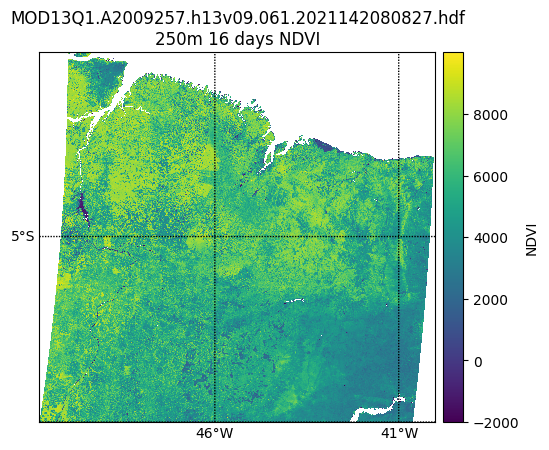

In [9]:


data = data3D.get().astype(float)

# Read attributes.
attrs = data3D.attributes(full=1)
lna=attrs["long_name"]
long_name = lna[0]
vra=attrs["valid_range"]
valid_range = vra[0]
fva=attrs["_FillValue"]
_FillValue = fva[0]
sfa=attrs["scale_factor"]
scale_factor = sfa[0]        
ua=attrs["units"]
units = ua[0]
aoa=attrs["add_offset"]
add_offset = aoa[0]

# Apply the attributes to the data.
invalid = np.logical_or(data < valid_range[0], data > valid_range[1])
invalid = np.logical_or(invalid, data == _FillValue)
data[invalid] = np.nan
data = (data - add_offset) * scale_factor
data = np.ma.masked_array(data, np.isnan(data))
data = data / scale_factor

# Construct the grid.  The needed information is in a global attribute
# called 'StructMetadata.0'.  Use regular expressions to tease out the
# extents of the grid.
fattrs = hdf.attributes(full=1)
ga = fattrs["StructMetadata.0"]
gridmeta = ga[0]
ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                          (?P<upper_left_x>[+-]?\d+\.\d+)
                          ,
                          (?P<upper_left_y>[+-]?\d+\.\d+)
                          \)''', re.VERBOSE)

match = ul_regex.search(gridmeta)
x0 = np.float64(match.group('upper_left_x'))
y0 = np.float64(match.group('upper_left_y'))

lr_regex = re.compile(r'''LowerRightMtrs=\(
                          (?P<lower_right_x>[+-]?\d+\.\d+)
                          ,
                          (?P<lower_right_y>[+-]?\d+\.\d+)
                          \)''', re.VERBOSE)
match = lr_regex.search(gridmeta)
x1 = np.float64(match.group('lower_right_x'))
y1 = np.float64(match.group('lower_right_y'))

nx, ny = data.shape
x = np.linspace(x0, x1, nx)
y = np.linspace(y0, y1, ny)
xv, yv = np.meshgrid(x, y)

sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
wgs84 = pyproj.Proj("+init=EPSG:4326") 
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)


# There is a wrap-around issue to deal with, as some of the grid extends
# eastward over the international dateline.  Adjust the longitude to avoid
# a smearing effect.
lon[lon < 0] += 360

m = Basemap(projection='merc', resolution='l',
            llcrnrlat=np.min(lat), urcrnrlat = np.max(lat),
            llcrnrlon=np.min(lon), urcrnrlon = np.max(lon))                
#m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(np.floor(np.min(lat)), np.ceil(np.max(lat)), 5),
                labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(np.floor(np.min(lon)), np.ceil(np.max(lon)), 5),
                labels=[0, 0, 0, 1])

# Subset data if you don't see any plot due to limited memory.
# m.pcolormesh(lon[::2,::2], lat[::2,::2], data[::2,::2], latlon=True)
m.pcolormesh(lon, lat, data, latlon=True)

cb = m.colorbar()
cb.set_label(units)

basename = os.path.basename(file)
plt.title('{0}\n{1}'.format(basename, long_name))
plt.savefig(f"../images/{basename.replace('.hdf','.png')}", dpi=1200)
plt.show()

In [13]:
data * 0.0001

masked_array(
  data=[[0.26630000000000004, 0.1653, 0.6788000000000001, ..., --, --,
         --],
        [0.6223000000000001, 0.1653, 0.6033000000000001, ..., --, --, --],
        [0.8007000000000001, 0.6774, 0.6967, ..., --, --, --],
        ...,
        [0.7202000000000001, 0.7397, 0.6686000000000001, ...,
         0.31620000000000004, 0.3154, 0.31620000000000004],
        [0.6644, 0.7397, 0.8197, ..., 0.32170000000000004, 0.3154,
         0.3225],
        [0.6644, 0.6527000000000001, 0.5958, ..., 0.3264, 0.3173,
         0.32580000000000003]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [16]:
def convert_sinu_to_dataframe(data3D):
    
    data = data3D.get().astype(float)

    # Read attributes.
    attrs = data3D.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    vra=attrs["valid_range"]
    valid_range = vra[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]

    # Apply the attributes to the data.
    invalid = np.logical_or(data < valid_range[0], data > valid_range[1])
    invalid = np.logical_or(invalid, data == _FillValue)
    data[invalid] = np.nan
    data = (data - add_offset) * scale_factor
    data = np.ma.masked_array(data, np.isnan(data))

    # Construct the grid.  The needed information is in a global attribute
    # called 'StructMetadata.0'.  Use regular expressions to tease out the
    # extents of the grid.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]
    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                              (?P<upper_left_x>[+-]?\d+\.\d+)
                              ,
                              (?P<upper_left_y>[+-]?\d+\.\d+)
                              \)''', re.VERBOSE)

    match = ul_regex.search(gridmeta)
    x0 = np.float64(match.group('upper_left_x'))
    y0 = np.float64(match.group('upper_left_y'))

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                              (?P<lower_right_x>[+-]?\d+\.\d+)
                              ,
                              (?P<lower_right_y>[+-]?\d+\.\d+)
                              \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float64(match.group('lower_right_x'))
    y1 = np.float64(match.group('lower_right_y'))
    nx, ny = data.shape
    
    # Generate the sinusoidal grid
    x = np.linspace(x0, x1, nx)
    y = np.linspace(y0, y1, ny)
    xv, yv = np.meshgrid(x, y)

    # Define projection transformation
    sinu = pyproj.Proj("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    wgs84 = pyproj.Proj("+init=EPSG:4326")

    # Convert all points to WGS84
    lon, lat = pyproj.transform(sinu, wgs84, xv, yv)

    data_list = []
    
    # Compute pixel size
    pixel_width = (x1 - x0) / nx
    pixel_height = (y1 - y0) / ny

    for i in range(ny - 1):
        for j in range(nx - 1):
            # Define pixel corners in sinusoidal projection
            min_x, min_y = xv[i, j], yv[i, j]
            max_x, max_y = min_x + pixel_width, min_y + pixel_height

            # Convert pixel corners to WGS84
            ll = pyproj.transform(sinu, wgs84, min_x, min_y)  # Lower-left
            lr = pyproj.transform(sinu, wgs84, max_x, min_y)  # Lower-right
            ur = pyproj.transform(sinu, wgs84, max_x, max_y)  # Upper-right
            ul = pyproj.transform(sinu, wgs84, min_x, max_y)  # Upper-left

            # Create WKT polygon
            polygon = Polygon([ll, lr, ur, ul, ll])
            data_list.append((data[i, j], polygon.wkt))

    # Create DataFrame
    df = pd.DataFrame(data_list, columns=["value", "wkt"])
    
    return df

In [18]:
from shapely.geometry import Polygon, MultiPolygon

In [19]:
df = convert_sinu_to_dataframe(data3D)

/opt/homebrew/anaconda3/envs/ndvi/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/2x/t13x4mn107zd1xc9j8ks6q300000gn/T/ipykernel_90057/1318807926.py:63: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = pyproj.transform(sinu, wgs84, xv, yv)
/var/folders/2x/t13x4mn107zd1xc9j8ks6q300000gn/T/ipykernel_90057/1318807926.py:78: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ll = pyproj.transform(sinu, wgs84, min_x, min_y)  # Lower-left
/var/folders/2x/t13x4mn107zd1xc9

KeyboardInterrupt: 